In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from helpers.helper_functions import *

# Handling text 2 exercise
[Handling text exercisses ADApted drom ADA 2018 final exam]

The Sheldon Cooper we all know and love (OK, some of us might not know him, and some might not love him) from the TV series "The Big Bang Theory" has gotten into an argument with Leonard from the same TV show. Sheldon insists that he knows the show better than anyone, and keeps making various claims about the show, which neither of them know how to prove or disprove. The two of them have reached out to you ladies and gentlemen, as data scientists, to help them. You will be given the full script of the series, with information on the episode, the scene, the person saying each dialogue line, and the dialogue lines themselves.

Leonard has challenged several of Sheldon's claims about the show, and throughout this exam you will see some of those and you will get to prove or disprove them, but remember: sometimes, we can neither prove a claim, nor disprove it!

## Task A: Picking up the shovel

**Note: You will use the data you preprocess in this task in all the subsequent ones.**

Our friends' argument concerns the entire show. We have given you a file in the `data/` folder that contains the script of every single episode. New episodes are indicated by '>>', new scenes by '>', and the rest of the lines are dialogue lines. Some lines are said by multiple people (for example, lines indicated by 'All' or 'Together'); **you must discard these lines**, for the sake of simplicity. However, you do not need to do it for Q1 in this task -- you'll take care of it when you solve Q2.

**Q1**. Your first task is to extract all lines of dialogue in each scene and episode, creating a dataframe where each row has the episode and scene where a dialogue line was said, the character who said it, and the line itself. You do not need to extract the proper name of the episode (e.g. episode 1 can appear as "Series 01 Episode 01 - Pilot Episode", and doesn't need to appear as "Pilot Episode"). Then, answer the following question: In total, how many scenes are there in each season? We're not asking about unique scenes; the same location appearing in two episodes counts as two scenes. You can use a Pandas dataframe with a season column and a scene count column as the response.

**Note: The data refers to seasons as "series".**

In [88]:
import regex as re

In [136]:
path = 'data/all_scripts.txt'

# Read the file into a list of lines
with open(path, 'r', encoding = 'utf8') as file:
    lines = file.readlines()

# Create a list of dictionaries, where each dictionary represents a record
df = pd.DataFrame(columns=['Series', 'Episode', 'Scene', 'Character', 'Line'])

# Iterate through each line, current_entry = one log entry with all columns, df = list of all votee/voter pairs
for line in lines:
    line = line.strip('\n').strip()
    if line.startswith('>> '):
        _, serie, episode_nb, _ = re.split('>> Series | Episode | – ', string=line)
        continue
    elif line.startswith('> '):
        scene = line[2:]
        continue
    else :
        try:
            charact, dialogue = line.split(':', 1)
        except:
            print(line)
        df.loc[len(df)] = ({'Series': serie, 'Episode': episode_nb, 'Scene': scene,'Character': charact, 'Line': dialogue})
df

,Series,Episode,Scene,Character,Line
0,01,01,A corridor at a sperm bank.,Sheldon,So if a photon is directed through a plane wi...
1,01,01,A corridor at a sperm bank.,Leonard,"Agreed, what’s your point?"
2,01,01,A corridor at a sperm bank.,Sheldon,"There’s no point, I just think it’s a good id..."
3,01,01,A corridor at a sperm bank.,Leonard,Excuse me?
4,01,01,A corridor at a sperm bank.,Receptionist,Hang on.
...,...,...,...,...,...
51287,10,24,Sheldon’s office.,Ramona,"Mmm. No big deal, I enjoy spending time with ..."
51288,10,24,Sheldon’s office.,Sheldon,"And I with you. Question, are you seeking a r..."
51289,10,24,Sheldon’s office.,Ramona,What if I were?
51290,10,24,Sheldon’s office.,Sheldon,"Well, that would raise a number of problems. ..."


In [137]:
print('Number of scenes in each season:')
df.groupby(['Series', 'Episode', 'Scene']).Scene.first().groupby('Series').size()

Number of scenes in each season:


Series
01    157
02    205
03    193
04    219
05    198
06    211
07    207
08    191
09    177
10    189
Name: Scene, dtype: int64

**Q2**. Now, let's define two sets of characters: all the characters, and recurrent characters. Recurrent characters are those who appear in more than one episode. For the subsequent sections, you will need to have a list of recurrent characters. Assume that there are no two _named characters_ (i.e. characters who have actual names and aren't referred to generically as "little girl", "grumpy grandpa", etc.) with the same name, i.e. there are no two Sheldons, etc. Generate a list of recurrent characters who have more than 90 dialogue lines in total, and then take a look at the list you have. If you've done this correctly, you should have a list of 20 names. However, one of these is clearly not a recurrent character. Manually remove that one, and print out your list of recurrent characters. To remove that character, pay attention to the _named character_ assumption we gave you earlier on. **For all the subsequent questions, you must only keep the dialogue lines said by the recurrent characters in your list.**

In [35]:
print(f'Number of line total: {len(df)}')
df = df[~df.Character.isin(['All', 'Together'])]
print(f'Number of line without all and together: {len(df)}')


Number of line total: 51292
Number of line without all and together: 51185


In [36]:
rec_char = df.groupby('Character').agg({('n_episode', lambda x: x.nunique()), ('n_dialogue', lambda x: x.size)}).Episode
rec_char = rec_char[(rec_char.n_episode > 1) & (rec_char.n_dialogue > 90)].index
print(f'Number of reccurent characters: {rec_char.size}')
rec_char = rec_char[rec_char != 'Man']

df_rec = df[df.Character.isin(rec_char)]
display(df_rec.Character.unique())

Number of reccurent characters: 20


array(['Sheldon', 'Leonard', 'Penny', 'Howard', 'Raj', 'Mrs Cooper',
       'Leslie', 'Kripke', 'Beverley', 'Stuart', 'Bernadette', 'Wil',
       'Mrs Wolowitz', 'Zack', 'Amy', 'Priya', 'Arthur', 'Bert', 'Emily'],
      dtype=object)

## Task B: Read the scripts carefully

### Part 1: Don't put the shovel down just yet

**Q3**. From each dialogue line, replace punctuation marks (listed in the EXCLUDE_CHARS variable provided in `helpers/helper_functions.py`) with whitespaces, and lowercase all the text. **Do not remove any stopwords, leave them be for all the questions in this task.**

In [37]:
def clean_line(line:str):
    for element in EXCLUDE_CHARS:
        line = line.replace(element, ' ')
    return line.lower()

In [38]:
df_rec.Line = df_rec.Line.apply(clean_line)
df_rec

/var/folders/6p/skl5q4mn4kqcwg0hbd513bqr0000gn/T/ipykernel_19196/2892075834.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rec.Line = df_rec.Line.apply(clean_line)


,Series,Episode,Character,Line
0,01,01,Sheldon,so if a photon is directed through a plane wi...
1,01,01,Leonard,agreed what s your point
2,01,01,Sheldon,there s no point i just think it s a good id...
3,01,01,Leonard,excuse me
5,01,01,Leonard,one across is aegean eight down is nabakov ...
...,...,...,...,...
51284,10,24,Sheldon,uh breakfast yes lunch no i did have a cou...
51286,10,24,Sheldon,how thoughtful thank you
51288,10,24,Sheldon,and i with you question are you seeking a r...
51290,10,24,Sheldon,well that would raise a number of problems ...


**Q4**. For each term, calculate its "corpus frequency", i.e. its number of occurrences in the entire series. Visualize the distribution of corpus frequency using a histogram. Explain your observations. What are the appropriate x and y scales for this plot?

In [39]:
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

In [151]:
vectorizer = CountVectorizer(analyzer='word')
count = vectorizer.fit_transform(df_rec.Line)
corpus_freq = count.sum(axis=0)

In [152]:
vectorizer.get_feature_names_out().size
#np.ravel(corpus_freq).size

20484

In [155]:
freqs_by_words = pd.DataFrame({'word': vectorizer.get_feature_names_out() , 'freq': np.ravel(corpus_freq)})
freqs_by_words.freq.sum()

525944

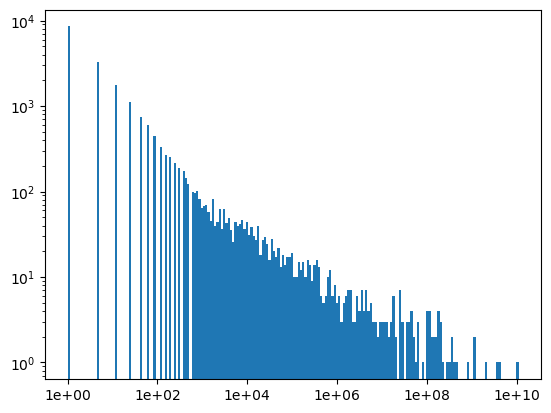

In [48]:
data = np.log(np.ravel(corpus_freq))
plt.hist(x=data, bins=200, log=True)
plt.xticks(ticks=np.arange(np.min(data), np.max(data), 2), labels=[f'{10**x:.0e}'.format(x) for x in np.arange(11, step=2)])
plt.show()

### Part 2: Talkativity
**Q5**. For each of the recurrent characters, calculate their total number of words uttered across all episodes. Based on this, who seems to be the most talkative character?

In [60]:
nb_words = pd.DataFrame(count.sum(axis = 1))
nb_words['Character'] = df_rec.Character
nb_words.groupby('Character').sum().sort_values(by=0, ascending=False)

,0
Character,
Sheldon,121018
Leonard,102459
Penny,77651
Howard,59045
Raj,48884
Amy,34258
Bernadette,26942
Stuart,7038
Priya,2619


## Task D: The Detective's Hat

Sheldon claims that given a dialogue line, he can, with an accuracy of above 70%, say whether it's by himself or by someone else. Leonard contests this claim, since he believes that this claimed accuracy is too high.

**Q6**. Divide the set of all dialogue lines into two subsets: the training set, consisting of all the seasons except the last two, and the test set, consisting of the last two seasons.

In [62]:
from sklearn.model_selection import train_test_split
all_season = df_rec.Series.unique()
display(all_season)
train_df = df_rec[df_rec.Series.isin(all_season[:-2])]
test_df = df_rec[df_rec.Series.isin(all_season[-2:])]

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10'],
      dtype=object)

**Q7**. Find the set of all words in the training set that are only uttered by Sheldon. Is it possible for Sheldon to identify himself only based on these? Use the test set to assess this possibility, and explain your method.

In [72]:
out_train = train_df.Character == 'Sheldon'
out_test = test_df.Character == 'Sheldon'

In [81]:
vectorizer = TfidfVectorizer()
vectorizer.fit_transform(train_df[out_train].Line)
Sheldon_words = vectorizer.get_feature_names_out()

vectorizer = TfidfVectorizer()
vectorizer.fit_transform(train_df[~out_train].Line)
Other_words = vectorizer.get_feature_names_out()

Sheldon_unique = [i for i in Sheldon_words if i not in Other_words]
np.array(Sheldon_unique)

array(['000lb', '01100111', '0700', ..., 'zur', 'zzzzzzzzz', 'être'],
      dtype='<U18')

In [158]:
pred_Sheldon = test_df.Line.apply(lambda x: any(element in Sheldon_unique for element in x)) 
accuracy = (pred_Sheldon == out_test).sum()/len(out_test)
accuracy

0.7800177008555413